# Metric Learning on Video Frames using N-Pair Loss

### Import Libraries and Check GPU

In [1]:
import torch
from torchvision import transforms, datasets, models
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from IPython.display import clear_output
from time import sleep

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Directory Setup for PyTorch DatasetFolder

In [2]:
directory = ['/scratch/vvg239/headcam/frames', '/scratch/vvg239/headcam/moving_mnist/mm_folder']

def folder_setup(dir_name):
    """One Time Directory Setup for DatasetFolder"""
    file_list = os.listdir(dir_name)
    for file in file_list:
        fdr = dir_name + file[6:-4]
        os.mkdir(fdr, mode = 0o700)
        os.rename(dir_name + file, fdr + "/" + file)
        
#folder_setup(directory[1])

### Moving MNIST / Saycam Visualization

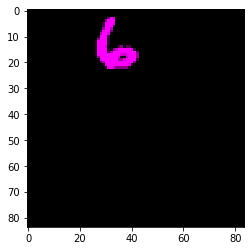

In [3]:
use_moving_mnist = True

filepath = ['frames/0/video_0.npy', 'moving_mnist/mm_folder/0/np_0.npy']
frames = np.load(filepath[use_moving_mnist])
print(frames.shape)

def plot_videoframes(frames):
    for i in range(min(frames.shape[0], 40)):
        plt.imshow(frames[i, :, :, :], interpolation='nearest')
        plt.show()
        sleep(0.01)
        clear_output(wait=True)

    plt.close()

plot_videoframes(frames)

### Setting up PyTorch DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


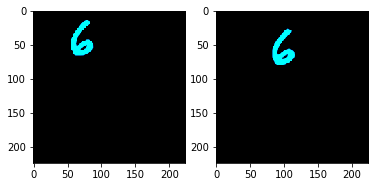

In [4]:
class NpyVideoFolder(datasets.DatasetFolder):
    
    def __init__(self, root, transform=None, distance=5, max_distance=15, update_after=0):
        super().__init__(root, loader=self.default_loader, transform=None, extensions='.npy')
        self.counter = 0
        self.distance = distance
        self.max_distance = max_distance
        self.update_after = update_after
        self.preprocess = transform
    
    def default_loader(self, path):
        """Load Numpy Files into PyTorch Dataset. Returns array of the form 2x3xWxH (as used in PyTorch)"""
        self.counter += 1
        if(self.counter == self.update_after):
            self.counter = 0
            self.distance += 1
            self.distance = min(self.distance, self.max_distance)
            print("Distance Updated to %d!!" % self.distance)
        samples = torch.from_numpy(np.load(path))
        x = np.random.randint(samples.shape[0]-self.distance)
        sample_a = self.preprocess(samples[x].permute(2,0,1))
        sample_p = self.preprocess(samples[x + self.distance].permute(2,0,1))
        return torch.stack([sample_a,sample_p],dim=0)

## Frame Visualization Helper
def viz_helper(data_loader, num_vid):
    batch, _ = iter(data_loader).next()
    video_frames = batch[num_vid]
    video_frames = video_frames.permute(0,2,3,1)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.imshow(video_frames[0])
    ax2.imshow(video_frames[1])
    
transform = transforms.Compose([transforms.ToPILImage(), 
                                transforms.Resize(224), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = NpyVideoFolder(root=directory[use_moving_mnist], transform=transform, distance=5, max_distance=20, update_after=3000)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=30, shuffle=True, num_workers=0)
viz_helper(data_loader, 2)

### Setting the Network and N-Pair Loss Function

In [5]:
model = models.alexnet()
classifier = nn.Sequential(#nn.Dropout(0.1),
                           nn.Linear(9216,4096),
                           nn.ReLU(inplace=True),
                           #nn.Dropout(0.1),
                           nn.Linear(4096,10))
model.classifier = classifier
print(torch.mean(model.features[8].weight))

# model = models.resnet50()
# model.fc = nn.Linear(2048,100)
# print(model)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


def minibatch_n_pair_loss(batch):
    loss = 0.0
    N = batch.shape[0]//2
    for i in range(N):
        negative_samples = torch.cat((batch[N:N+i], batch[N+i+1:]),dim=0)
        loss += n_pair_loss(batch[i], batch[N+i], negative_samples) #+ n_pair_loss(batch[N+i], batch[i], negative_samples)
    return loss/N

def n_pair_loss(anchor, positive, negatives):
    #sim_pos = F.cosine_similarity(positive.unsqueeze(0), anchor.unsqueeze(0), dim=1)
    #sim_negs = F.cosine_similarity(negatives, anchor.repeat(negatives.shape[0],1), dim=1)
    #logits = torch.cat((sim_pos,sim_negs)).unsqueeze(0)
    n_pair = torch.cat((positive.unsqueeze(0), negatives))
    sims = F.cosine_similarity(n_pair, anchor.repeat(n_pair.shape[0], 1), dim=1)
    logits = sims.unsqueeze(0)
    labels = torch.zeros(1).to(device, dtype=torch.long)
    ret = F.cross_entropy(logits, labels)
    return ret

tensor(-2.8974e-05, grad_fn=<MeanBackward0>)


### Training the Network

In [ ]:
###### Single Run Training ######
model.train()
batch_frames, _ = iter(data_loader).next()
optimizer.zero_grad()
x = batch_frames[:,0]
y = batch_frames[:,1]
minibatch = torch.cat((x,y),dim=0)
minibatch = minibatch.to(device)
minibatch = model(minibatch)
loss = minibatch_n_pair_loss(minibatch)
loss.backward()
optimizer.step()

In [6]:
train_losses = []
epochs = 500
model.train()

for epoch in range(epochs):
    running_loss = 0
    for batch_frames, _ in data_loader:
        optimizer.zero_grad()
        x = batch_frames[:,0]
        y = batch_frames[:,1]
        minibatch = torch.cat((x,y),dim=0)
        minibatch = minibatch.to(device)
        minibatch = model(minibatch)
        loss = minibatch_n_pair_loss(minibatch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        train_losses.append(running_loss)
        scheduler.step()
        print("Epoch: %3d | Running Loss: %f | LR: %.9f" % (epoch, running_loss, optimizer.param_groups[0]['lr']))
        
plt.plot(train_losses)

Epoch:   0 | Running Loss: 16.174002 | LR: 0.000100000
Distance Updated to 6!!
Epoch:   1 | Running Loss: 15.359880 | LR: 0.000100000
Epoch:   2 | Running Loss: 15.094219 | LR: 0.000100000
Distance Updated to 7!!
Epoch:   3 | Running Loss: 14.954868 | LR: 0.000100000
Epoch:   4 | Running Loss: 14.502314 | LR: 0.000100000
Distance Updated to 8!!
Epoch:   5 | Running Loss: 14.073442 | LR: 0.000100000
Epoch:   6 | Running Loss: 14.186512 | LR: 0.000100000
Distance Updated to 9!!
Epoch:   7 | Running Loss: 14.426297 | LR: 0.000100000
Epoch:   8 | Running Loss: 14.184960 | LR: 0.000100000
Distance Updated to 10!!
Epoch:   9 | Running Loss: 14.443391 | LR: 0.000100000
Epoch:  10 | Running Loss: 14.368152 | LR: 0.000100000
Distance Updated to 11!!
Epoch:  11 | Running Loss: 14.211472 | LR: 0.000100000
Epoch:  12 | Running Loss: 14.109494 | LR: 0.000100000
Distance Updated to 12!!
Epoch:  13 | Running Loss: 13.932379 | LR: 0.000100000
Epoch:  14 | Running Loss: 13.701602 | LR: 0.000100000
Dist

Epoch: 122 | Running Loss: 12.928986 | LR: 0.000010000
Distance Updated to 20!!
Epoch: 123 | Running Loss: 12.830965 | LR: 0.000010000
Epoch: 124 | Running Loss: 12.953856 | LR: 0.000010000
Distance Updated to 20!!
Epoch: 125 | Running Loss: 12.970655 | LR: 0.000010000
Epoch: 126 | Running Loss: 12.853851 | LR: 0.000010000
Distance Updated to 20!!
Epoch: 127 | Running Loss: 12.844937 | LR: 0.000010000
Epoch: 128 | Running Loss: 12.881278 | LR: 0.000010000
Distance Updated to 20!!
Epoch: 129 | Running Loss: 12.932003 | LR: 0.000010000
Epoch: 130 | Running Loss: 12.802006 | LR: 0.000010000
Distance Updated to 20!!
Epoch: 131 | Running Loss: 12.937062 | LR: 0.000010000
Epoch: 132 | Running Loss: 12.954749 | LR: 0.000010000
Distance Updated to 20!!
Epoch: 133 | Running Loss: 12.802821 | LR: 0.000010000


KeyboardInterrupt: 

In [ ]:
model = models.resnet50()
model.fc = nn.Linear(2048,100)
print(model)

In [ ]:
test = torch.zeros(6,3)
test[0,0] = 1.0
test[1,1] = 1.0
test[2,2] = 1.0
test[3,0] = 1.0
test[4,1] = 1.0
test[5,2] = 1.0
test = test.to(device)
minibatch_n_pair_loss(test).item()